In [36]:
import os
import wandb
import logging
from pytorch_lightning.utilities.seed import seed_everything

from DLIP.utils.loading.initialize_wandb import initialize_wandb
from DLIP.utils.loading.load_data_module import load_data_module
from DLIP.utils.loading.load_model import load_model
from DLIP.utils.loading.load_transforms import load_transforms
from DLIP.utils.loading.load_trainer import load_trainer
from DLIP.utils.loading.merge_configs import merge_configs
from DLIP.utils.loading.prepare_directory_structure import prepare_directory_structure

from DLIP.utils.loading.split_parameters import split_parameters
from DLIP.utils.cross_validation.cv_trainer import CVTrainer

logging.basicConfig(level=logging.INFO)
logging.info("Initalizing model")

config_files = "/home/ws/sc1357/projects/devel/src/detectron/DLIP/experiments/configurations/base_cfg/cfg_inst_seg_base.yaml"

cfg_yaml = merge_configs(config_files)
experiment_name=cfg_yaml['experiment.name']['value']

config = initialize_wandb(
    cfg_yaml=cfg_yaml,
    experiment_dir=None,
    config_name=None,
    disabled=True
)

seed_everything(seed=cfg_yaml['experiment.seed']['value'])
parameters_splitted = split_parameters(config, ["model", "train", "data"])

model = load_model(parameters_splitted["model"],  checkpoint_path_str="/home/ws/sc1357/data/inst_seg_tests/first-shot/DetectronDataModule/Detectron2/0191/dnn_weights.ckpt")
_,_,trafo = load_transforms(parameters_splitted["data"])

INFO:root:Initalizing model
Global seed set to 1337


[06/17 14:12:52 detectron2]: Rank of current process: 0. World size: 1
[06/17 14:12:53 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.5 (default, Sep  4 2020, 07:30:14) [GCC 7.3.0]
numpy                   1.21.4
detectron2              0.6 @/home/ws/sc1357/miniconda3/envs/detectron/lib/python3.8/site-packages/detectron2
Compiler                GCC 9.3
CUDA compiler           CUDA 11.5
detectron2 arch flags   7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.10.0 @/home/ws/sc1357/miniconda3/envs/detectron/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   Quadro RTX 3000 (arch=7.5)
Driver version          495.46
CUDA_HOME               /usr/local/cuda
Pillow                  8.4.0
torchvision             0.11.1 @/home/ws/sc1357/miniconda3/envs/detectron/li

{'instances': Instances(num_instances=1, image_height=128, image_width=128, fields=[pred_boxes: Boxes(tensor([[ 86.5960,  38.6150, 105.4398,  57.4495]], device='cuda:0',
       grad_fn=<IndexBackward0>)), scores: tensor([0.9992], device='cuda:0', grad_fn=<IndexBackward0>), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}


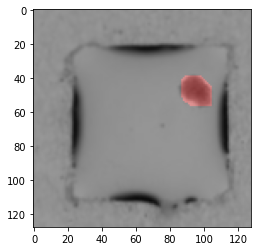

In [37]:
import tifffile
from skimage.transform import resize
import numpy as np

import matplotlib.pyplot as plt
from skimage.color import label2rgb

img     = tifffile.imread("/home/ws/sc1357/data/2022_DMA_Spheroid_Detection_split/test/samples/spot_row_18_col11.tif")
label   =  tifffile.imread("/home/ws/sc1357/data/2022_DMA_Spheroid_Detection_split/test/labels/spot_row_23_col00_label.tif")
model.model.eval()
model.model.training = False
img_dict = dict()
img_dict["image"] = trafo[0](img)[0]
input = [img_dict]
res = model.model(input)
print(res[0])


# label = np.zeros((128,128))  
# box = res[0]["instances"].pred_boxes[0].tensor.detach().cpu().numpy()
# label[int(box[0,1]):int(box[0,3]),int(box[0,0]):int(box[0,2])] = 1
#image_label_overlay = label2rgb(label, image=resize(img,(128,128)), bg_label=0)
#image_label_overlay = label2rgb(resize(label.squeeze(),(128,128), order=0), image=resize(img,(128,128)), bg_label=0)
image_label_overlay = label2rgb(res[0]["instances"].pred_masks[0,:].cpu().numpy(), image=resize(img,(128,128)), bg_label=0)

# image_label_overlay[10]=0
plt.imshow(image_label_overlay)